In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Read the data into a Pandas dataframe
data = pd.read_csv("car-reviews.csv")

In [71]:
# Cleaning the data
# Using stemming to reduce the number of features whilst retaining word meaning

def stem_words(corpus):
    stemmer = SnowballStemmer("english")
    tokens = corpus.split()
    stemmed_tokens = []
    for token in tokens:
        if not token.isalpha():
            token = 'NUM' # any string with a number in it changed to 'NUM'
        stemmed_tokens.append(stemmer.stem(token))
    return ' '.join(stemmed_tokens)

training, testing = sklearn.model_selection.train_test_split(data, train_size = 0.8, test_size = 0.2, shuffle = True)

In [72]:
training['Stemmed'] = training['Review'].apply(stem_words) # adding new df column with stemmed version of the text
testing['Stemmed'] = testing['Review'].apply(stem_words)

<ipython-input-72-4fc820978b20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['Stemmed'] = training['Review'].apply(stem_words) # adding new df column with stemmed version of the text
<ipython-input-72-4fc820978b20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['Stemmed'] = testing['Review'].apply(stem_words)


In [73]:
# Here you can see what the stemming function has done to the text
print(training.head)

<bound method NDFrame.head of      Sentiment                                             Review  \
829        Pos   My husband recently traded our 1996 B4000 Maz...   
1197       Pos   The ford Taurus is a great car for young or o...   
1236       Pos   I recently had the chance to rent a loaded Es...   
275        Neg   Last year  my wife needed a newer car than th...   
117        Neg   I was lucky enough to get to drive my best fr...   
...        ...                                                ...   
557        Neg   Being that I rented at least 5 of these babie...   
6          Neg   We bought this van in 1999  after having been...   
1039       Pos   A few years ago we bought a Ford Explorer use...   
155        Neg   We bought a new Explorer in 1995 and felt we ...   
849        Pos   When we first married  my husband and I thoug...   

                                                Stemmed  
829   my husband recent trade our num num mazda for ...  
1197  the ford taurus is 

In [74]:
# Extracting the features from the training data and counting their frequency in each review
""" The CountVectorizer module from Sklearn allows you to easily vectorize (tokenize)
 the dataset, and specify stopwords and a minimum and maximum frequency.
 Here I am using a minimum frequency of 0.01, so any feature (word)
 which appears in less than 1 in 100 reviews is dropped from the training set. This also removes all punctuation."""

vect = CountVectorizer(stop_words='english', min_df=0.01, max_df=1.0, ngram_range=(1,1))
vect.fit(training['Stemmed']) # extracts features from the training dataset which conform to the set conditions

# feature counting for training and testing datasets, output is of size (n reviews, n features).
train_features = vect.transform(training['Stemmed']) 
test_features = vect.transform(testing['Stemmed'])
        
train_labels = np.array(training['Sentiment'])
test_labels = np.array(testing['Sentiment'])

In [75]:
nb_clf = MultinomialNB(alpha = 1) # creating a Naive Bayes classifier with laplace smoothing of 1

In [84]:
# Uses an inputted clf and the training features to predict sentiment values

def predict(clf, train_feat, train_lab, test_feat, test_lab):
    clf.fit(train_features, train_labels)
    train_pred = clf.predict(train_features)
    test_pred = clf.predict(test_features)

    train_conf = confusion_matrix(train_labels, train_pred)
    test_conf = confusion_matrix(test_labels, test_pred)
        
    train_display = ConfusionMatrixDisplay(train_conf, display_labels = clf.classes_)
    test_display = ConfusionMatrixDisplay(test_conf, display_labels = clf.classes_)
        
    print(f'Classified using {type(clf)}.\n{train_features.shape[1]} features identified, with a total feature frequency across the entire dataset of {train_features.sum() + test_features.sum()}.\n')
    print(f'Training report:\n {classification_report(train_labels, train_pred)}\n')
    train_display.plot()
    
    print(f'Testing report:\n {classification_report(test_labels, test_pred)}')
    test_display.plot()


Classified using <class 'sklearn.naive_bayes.MultinomialNB'>.
1845 features identified, with a total feature frequency across the entire dataset of 261423.

Training report:
               precision    recall  f1-score   support

         Neg       0.86      0.82      0.84       552
         Pos       0.83      0.87      0.85       553

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105


Testing report:
               precision    recall  f1-score   support

         Neg       0.78      0.68      0.73       139
         Pos       0.71      0.81      0.76       138

    accuracy                           0.74       277
   macro avg       0.75      0.74      0.74       277
weighted avg       0.75      0.74      0.74       277



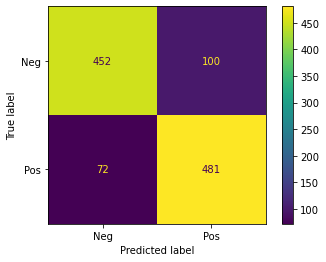

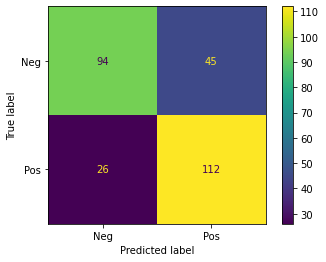

In [85]:
predict(nb_clf, train_features, train_labels, test_features, test_labels)

Classified using <class 'sklearn.svm._classes.SVC'>.
1845 features identified, with a total feature frequency across the entire dataset of 261423.

Training report:
               precision    recall  f1-score   support

         Neg       1.00      1.00      1.00       552
         Pos       1.00      1.00      1.00       553

    accuracy                           1.00      1105
   macro avg       1.00      1.00      1.00      1105
weighted avg       1.00      1.00      1.00      1105


Testing report:
               precision    recall  f1-score   support

         Neg       0.79      0.70      0.74       139
         Pos       0.73      0.81      0.77       138

    accuracy                           0.75       277
   macro avg       0.76      0.75      0.75       277
weighted avg       0.76      0.75      0.75       277



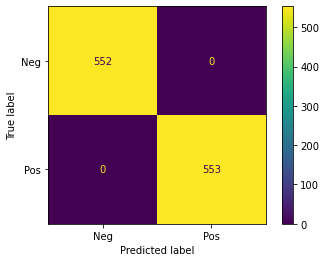

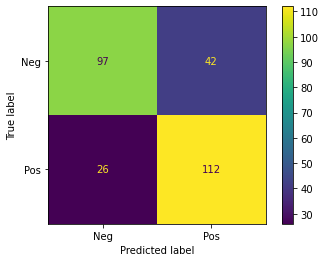

In [89]:
# Part 2 - using a linear Support Vector Machine
svm_clf = svm.SVC(kernel = 'linear')
predict(svm_clf, train_features, train_labels, test_features, test_labels)

### SVM vs Naive Bayes

By comparing the confusion matrix, one can see that 3 more negative reviews were correctly identified by the SVM compared to the Naive Bayes classifier. However, this is a very minor difference overall and it would not necessarily always perform better for different splits of the data. The classifiers can be assumed to have approximately the same accuracy.

For both classifiers the precision for negative reviews was slightly better than for positive reviews. This suggests that people are more likely to use overly negative language in their negative reviews which can be picked out by the classifiers.

